In [1]:
import numpy as np
DTYPE = np.float64
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
try:
    import flory
    
except ImportError:
    print("Installing 'flory' temporarily...")
    !pip install flory --quiet
    import flory

In [2]:
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i][j]*phi[i]*phi[j]

    return part_1 + part_2

In [3]:
# General Function for computing mergers of compartments

def mergers(concs:np.array, vols:np.array, merged_compartments:list):
    # Find the unmerged compartment(s)
    
    expected = len(vols)*(len(vols)+1)//2
    actual = np.sum(merged_compartments)
    unmerged = expected - actual

    print(concs)
    print(vols)
    print(unmerged)

    # Compute the merged volumes
    # subtract -1 from the merged_compartments idxs to maintain python idxing

    eta_merged = 0
    for compartment in merged_compartments:
        eta_merged += vols[compartment-1]
    # print(eta_merged)

    # Calculating the compositions of components in the merged compartment
    phi_1merged = (vols[merged_compartments[0]-1]*concs[0, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[0, merged_compartments[1]-1])/eta_merged
    phi_2merged = (vols[merged_compartments[0]-1]*concs[1, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[1, merged_compartments[1]-1])/eta_merged
    phi_3merged = 1 - phi_1merged - phi_2merged
    # print(phi_1merged, phi_2merged, phi_3merged)
    # print(phi_1merged + phi_2merged + phi_3merged)

    phi_in_kmerged = [phi_1merged, phi_2merged, phi_3merged]
    phi_in_kunmerged = [concs[0, unmerged-1], concs[1, unmerged-1], concs[2, unmerged-1]]
    # print(phi_in_kmerged)
    # print(phi_in_kunmerged)

    F_merged = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged-1]*floryHuggins(phi_in_kunmerged, chis)
    # print(F_merged)

    return phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged

    

In [4]:
def perturb_mergers(concs, vols, phi_in_kunmerged,phi_in_kmerged, eta_merged, unmerged, step_size:DTYPE, n_points:int):
    # phi_1merged = phi_in_kmerged[0]
    # phi_2merged = phi_in_kmerged[1]

    phi_1merged_perturbed = np.linspace(phi_in_kmerged[0] - n_points*step_size, phi_in_kmerged[0] + n_points*step_size, 2*n_points+1)
    phi_2merged_perturbed = np.linspace(phi_in_kmerged[1] - n_points*step_size, phi_in_kmerged[1] + n_points*step_size, 2*n_points+1)
    # print(phi_1merged_perturbed)
    # print(phi_2merged_perturbed)

    accepted_phi_1merged_perturbed = []
    accepted_phi_2merged_perturbed = []
    accepted_Fs_merged = []
    
    ctr = 0
    
    for phi_1m in phi_1merged_perturbed:
        for phi_2m in phi_2merged_perturbed:
            if phi_1m<0 or phi_2m<0 or phi_1m>1 or phi_2m>1:
                continue
            
            phi_3m = 1 - phi_1m - phi_2m
            if phi_3m<0 or phi_3m>1:
                continue
            
            # Concentrations in the unmerged compartment
            phi_1unmerged = (phi_global[0] - phi_1m*(eta_merged))/(vols[unmerged-1])
            phi_2unmerged = (phi_global[1] - phi_2m*(eta_merged))/(vols[unmerged-1])

            if phi_1unmerged<0 or phi_1unmerged>1 or phi_2unmerged<0 or phi_2unmerged>1:
                continue

            phi_3unmerged = 1 - phi_1unmerged - phi_2unmerged
            if phi_3unmerged<0 or phi_3unmerged>1:
                continue
            ctr+=1

            phi_in_kmerged = [phi_1m, phi_2m, phi_3m]
            phi_in_kunmerged =  [phi_1unmerged, phi_2unmerged, phi_3unmerged]
            
            F = 0
            F = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged-1]*floryHuggins(phi_in_kunmerged, chis)

            accepted_phi_1merged_perturbed.append(phi_1m)
            accepted_phi_2merged_perturbed.append(phi_2m)
            accepted_Fs_merged.append(F)
    
    print(ctr/len(phi_1merged_perturbed)**2)

    df = pd.DataFrame()
    df["phi_1mod"] = accepted_phi_1merged_perturbed
    df["phi_2mod"] = accepted_phi_2merged_perturbed
    df["F"] = accepted_Fs_merged
    
    return df


In [20]:
step_size = 0.001
n_points = 1000

In [83]:
# Interaction matrix
chis = np.array([[0, 3.0, 3.5], [3.0, 0.0, 3.0], [3.5, 3.0, 0.0]], dtype = DTYPE)

# Global value of phis
phi_global = np.array([0.1, 0.3, 0.6], dtype = DTYPE)

# Equilibrium 3 phase solution
phases = flory.find_coexisting_phases(3, chis, phi_global, progress=False)

print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")

# Take the transpose as the notation is different:
# For me: phi_ij = component i in compartment j
# For flory: phi_ji = component i in compartment j (OR I THINK SO!)

vols = phases.volumes

phases.fractions = np.transpose(phases.fractions)
concs = phases.fractions


Equlibrium phase volumes: [0.04648321 0.29794635 0.65557044]
Equlibrium phase concentrations:
[[0.87007262 0.08074888 0.04917858]
 [0.09168545 0.81662767 0.09168684]
 [0.04917684 0.08074693 0.87007625]]


In [84]:
# Compute the system's phase separated Free Energy'
# Free energy of the 3 phase system

F_flory = 0
for i in range(len(phases.volumes)):
    F_flory += phases.volumes[i]*floryHuggins(phases.fractions[:, i], chis)

print(F_flory)


-0.10741238920568458


In [91]:
merged_compartments = [2, 3]
phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged = mergers(concs, vols, merged_compartments)

[[0.87007262 0.09168545 0.04917684]
 [0.08074888 0.81662767 0.08074693]
 [0.04917858 0.09168684 0.87007625]]
[0.04648321 0.29794635 0.65557044]
1


In [92]:
df = perturb_mergers(concs, vols, phi_in_kunmerged,phi_in_kmerged, eta_merged, unmerged, step_size, n_points)

0.0002937062203530918


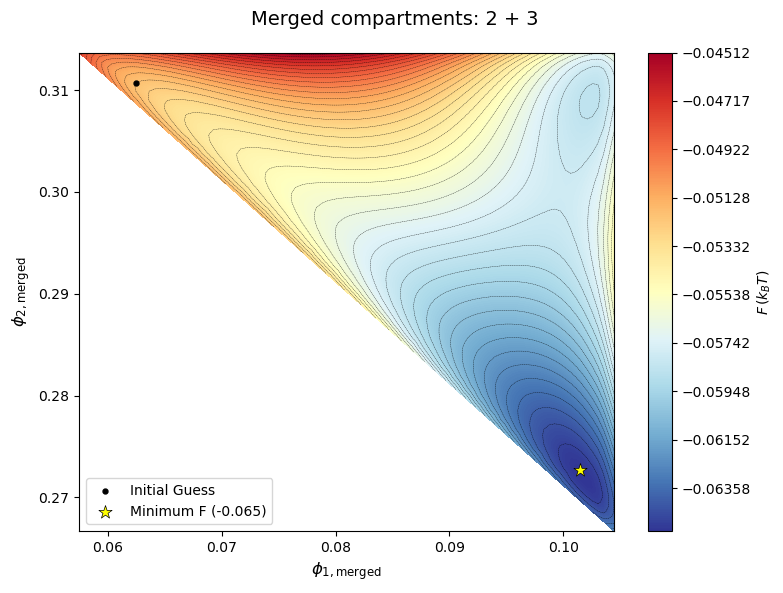

In [93]:
phi1_grid = np.linspace(min(df["phi_1mod"]), max(df["phi_1mod"]), 100)
phi2_grid = np.linspace(min(df["phi_2mod"]), max(df["phi_2mod"]), 100)
phi1_mesh, phi2_mesh = np.meshgrid(phi1_grid, phi2_grid)

# Interpolate F values onto the grid
F_grid = griddata(
    (df["phi_1mod"], df["phi_2mod"]), 
    df["F"], 
    (phi1_mesh, phi2_mesh), 
    method='cubic'
)

# Create the contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = plt.contourf(phi1_mesh, phi2_mesh, F_grid, levels=1000, cmap = "RdYlBu_r")
plt.colorbar(contour, label=r'$F\, (k_BT)$')


# Mark the original point
ax.scatter(
    phi_in_kmerged[0], phi_in_kmerged[1], 
    color='black',
    marker = ".",
    s=50, 
    label='Initial Guess'
)

# Find the minimum free energy point
min_F_index = np.argmin(df["F"])
min_phi1 = df["phi_1mod"].iloc[min_F_index]
min_phi2 = df["phi_2mod"].iloc[min_F_index]
min_F = df["F"].iloc[min_F_index]

ax.scatter(
    min_phi1, min_phi2, 
    color='yellow', 
    s=100, 
    marker='*',
    edgecolor='black',
    linewidth=0.5,
    label=f'Minimum F ({min_F:.3f})'
)

# Add contour lines
CS = plt.contour(phi1_mesh, phi2_mesh, F_grid, levels=40, colors='k', linewidths=0.25)
# ax.clabel(CS, inline=True, fontsize=8)

ax.set_xlabel(r'$\phi_{1, \text{merged}}$', fontsize=12)
ax.set_ylabel(r'$\phi_{2, \text{merged}}$', fontsize=12)
plt.suptitle(f'Merged compartments: {merged_compartments[0]} + {merged_compartments[1]}', fontsize=14)
plt.legend(loc = "lower left")
plt.tight_layout()
